In [ ]:
# Imports & Setup
import os
import json
import torch
import torchaudio
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from collections import Counter
import matplotlib.pyplot as plt
import timm
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB


In [ ]:
# 1. Preprocessing
mel_transform = MelSpectrogram(
    sample_rate=16000,
    n_fft=1024,
    hop_length=320,
    n_mels=128
)
db_transform = AmplitudeToDB(top_db=80)

label_to_id = {"TVMA": 0, "TVFOURTEEN": 1, "TVYSEVEN": 2, "Non-Profane": 3}
id_to_label = {v: k for k, v in label_to_id.items()}



In [ ]:
# 2. Profanity Dataset (No VAD, filters silence via energy)
class ProfanityDataset(torch.utils.data.Dataset):
    def __init__(self, json_paths, audio_dir, transform=None, energy_threshold=0.001):
        self.audio_dir = audio_dir
        self.samples = self._build_sample_list(json_paths)
        self.transform = transform
        self.energy_threshold = energy_threshold

    def _build_sample_list(self, json_paths):
        samples = []
        for path in json_paths:
            with open(path) as f:
                data = json.load(f)
                missing = 0
                for entry in data:
                    if "label" not in entry or not entry["label"]:
                        missing += 1
                        continue

                    #  Extract local file ID from entry["id"]
                    local_id = str(entry["id"])
                    target_suffix = f"{local_id}_profane.mp3"

                    matched_file = None
                    for f_name in os.listdir(self.audio_dir):
                        if f_name.endswith(target_suffix):
                            matched_file = os.path.join(self.audio_dir, f_name)
                            break

                    if not matched_file:
                        print(f" No audio match found for {entry['audio']} → expected suffix: {target_suffix}")
                        continue

                    segments = sorted(entry["label"], key=lambda x: float(x["start"]))
                    last_end = 0.0

                    for seg in segments:
                        start = float(seg["start"])
                        end = float(seg["end"])
                        labels = seg["labels"]
                        if not labels:
                            continue
                        label = labels[0]

                        # Insert non-profane gap
                        if start > last_end:
                            samples.append((matched_file, last_end, start, label_to_id["Non-Profane"]))
                        samples.append((matched_file, start, end, label_to_id[label]))
                        last_end = end

            if missing > 0:
                print(f" Skipped {missing} entries without usable 'label' in {os.path.basename(path)}")
        return samples

    def __getitem__(self, idx):
        path, start, end, label = self.samples[idx]
        waveform, sr = torchaudio.load(path)
        start_i = int(start * sr)
        end_i = int(end * sr)

        # Skip short segments
        if start_i >= end_i:
            raise IndexError("Too short segment")

        waveform = waveform[:, start_i:end_i]

        if waveform.abs().mean() < self.energy_threshold:
            raise IndexError("Too quiet, skipping")

        if waveform.shape[1] < 16000:
            waveform = F.pad(waveform, (0, 16000 - waveform.shape[1]))
        else:
            waveform = waveform[:, :16000]

        if self.transform:
            mel = self.transform(waveform)
            mel = db_transform(mel)
            mel = torch.nn.functional.interpolate(mel.unsqueeze(0), size=(224, 224), mode='bilinear').squeeze()
            return mel, label
        return waveform, label

    def __len__(self):
        return len(self.samples)



In [ ]:
# 3. Wrapper to skip segments that are too silent
class SafeDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __getitem__(self, i):
        tries = 0
        while tries < len(self.indices):
            try:
                return self.dataset[self.indices[i]]
            except IndexError:
                i = (i + 1) % len(self.indices)
                tries += 1
        raise RuntimeError("All samples too quiet or invalid.")

    def __len__(self):
        return len(self.indices)



⚠️ No audio match found for /data/upload/1/29d79201-1039_profane.mp3 → expected suffix: 103_profane.mp3
⚠️ No audio match found for /data/upload/1/f586d074-1059_profane.mp3 → expected suffix: 113_profane.mp3
⚠️ No audio match found for /data/upload/1/c7f774c5-1106_profane.mp3 → expected suffix: 129_profane.mp3
⚠️ No audio match found for /data/upload/1/5823b03e-1145_profane.mp3 → expected suffix: 147_profane.mp3
⚠️ No audio match found for /data/upload/1/7cbbca82-1148_profane.mp3 → expected suffix: 149_profane.mp3
⚠️ No audio match found for /data/upload/1/2fd3201c-1168_profane.mp3 → expected suffix: 155_profane.mp3
⚠️ No audio match found for /data/upload/1/61da6c93-1176_profane.mp3 → expected suffix: 157_profane.mp3
⚠️ No audio match found for /data/upload/1/c739d442-1185_profane.mp3 → expected suffix: 159_profane.mp3
⚠️ No audio match found for /data/upload/1/aed1a276-1222_profane.mp3 → expected suffix: 177_profane.mp3
⚠️ No audio match found for /data/upload/1/d7b0f4e8-1237_profane

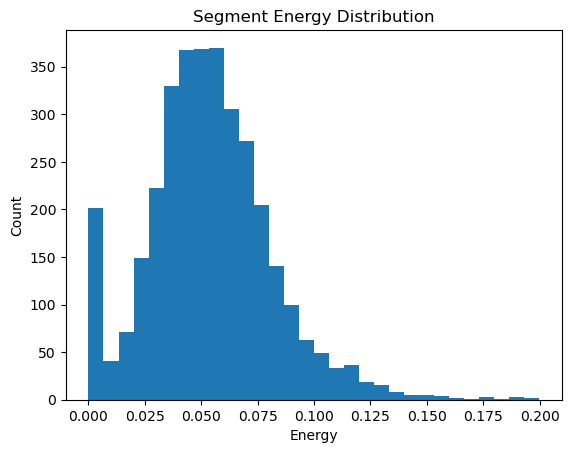

🔢 Class counts in split: Counter({3: 1247, 1: 561, 0: 471, 2: 313})
✅ Dataloaders created with class-balanced sampling for training
✅ Usable segments: 3241
📊 Usable class distribution: Counter({3: 1559, 1: 701, 0: 589, 2: 392})
📁 Matched Audio Files: 451
📊 Label counts across 20 batches: Counter({2: 82, 1: 81, 3: 80, 0: 77})


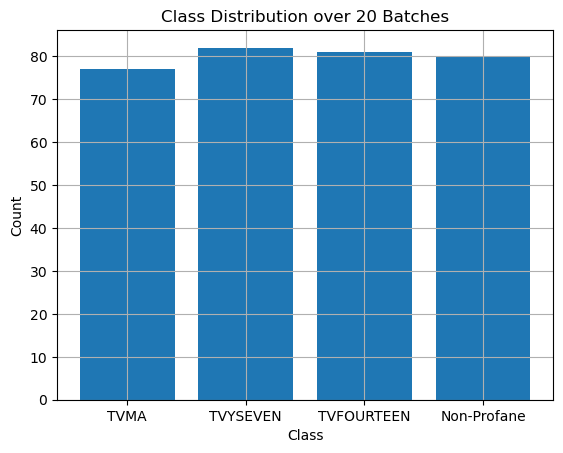

In [ ]:
from sklearn.model_selection import train_test_split

# Setup paths
profane_jsons = [
    "/Users/raj/University/AVS 8/AVS8_AAU_Audio_Main/Dataset_info/label/chamak.json",
    "/Users/raj/University/AVS 8/AVS8_AAU_Audio_Main/Dataset_info/label/ibtihaj.json",
    "/Users/raj/University/AVS 8/AVS8_AAU_Audio_Main/Dataset_info/label/shahrior.json"
]
audio_dir = "/Users/raj/University/AVS 8/AVS8_AAU_Audio_Main/Dataset_info/Dataset/profane"

# Build full dataset
full_dataset = ProfanityDataset(profane_jsons, audio_dir, mel_transform, energy_threshold=0.0)

# Energy check
energies = []
usable_indices = []
for i in range(len(full_dataset.samples)):
    try:
        path, start, end, label = full_dataset.samples[i]
        waveform, sr = torchaudio.load(path)
        start_i = int(start * sr)
        end_i = int(end * sr)

        if start_i >= end_i:
            continue  # skip too short segments

        segment = waveform[:, start_i:end_i]
        energy = segment.abs().mean().item()
        energies.append(energy)

        if energy >= 0.0005:  #  More tolerant thresholdan
            usable_indices.append(i)

    except Exception as e:
        print(f"[{i}] Error loading segment: {e}")
        continue

# Plot energy histogram
if energies:
    plt.hist(energies, bins=30)
    plt.title("Segment Energy Distribution")
    plt.xlabel("Energy")
    plt.ylabel("Count")
    plt.show()
else:
    print(" No segment energy could be measured.")

if len(usable_indices) == 0:
    raise RuntimeError(" No segments passed energy threshold. Try lowering it or debugging audio files.")

# Proceed with usable data
usable_labels = [full_dataset.samples[i][-1] for i in usable_indices]
train_idx, val_idx = train_test_split(usable_indices, test_size=0.2, stratify=usable_labels, random_state=42)

train_ds = SafeDatasetWrapper(full_dataset, train_idx)
val_ds = SafeDatasetWrapper(full_dataset, val_idx)


def get_class_weights_and_sampler(dataset, indices):
    label_counts = Counter([dataset.samples[i][-1] for i in indices])
    print(" Class counts in split:", label_counts)

    class_weights = {cls: 1.0 / count for cls, count in label_counts.items()}
    sample_weights = [class_weights[dataset.samples[i][-1]] for i in indices]

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    return sampler

# Create balanced sampler for training set
train_sampler = get_class_weights_and_sampler(full_dataset, train_idx)

#  Create dataloaders
train_loader = DataLoader(train_ds, batch_size=16, sampler=train_sampler)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False)

#  Print summary
print(f" Dataloaders created with class-balanced sampling for training")


print(f"Usable segments: {len(usable_indices)}")
print(f"Usable class distribution: {Counter(usable_labels)}")
print(f"Matched Audio Files: {len(set([s[0] for s in full_dataset.samples]))}")


from collections import Counter
import matplotlib.pyplot as plt

# Collect labels from N batches to inspect sampler behavior
def inspect_sampler_balance(loader, num_batches=10):
    all_labels = []

    for i, (mel, label) in enumerate(loader):
        all_labels.extend(label.cpu().numpy())
        if i + 1 >= num_batches:
            break

    label_counts = Counter(all_labels)
    print(f"Label counts across {num_batches} batches:", label_counts)

    # Bar plot
    plt.bar([id_to_label[l] for l in label_counts.keys()], label_counts.values())
    plt.title(f"Class Distribution over {num_batches} Batches")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()

# Run it
inspect_sampler_balance(train_loader, num_batches=20)



In [ ]:
# 5. AST Model Definition
import torch.nn as nn

model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.patch_embed.proj = nn.Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
model.head = nn.Linear(model.head.in_features, len(label_to_id))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


In [ ]:
#  6. Training Loop with AUC and Class-Wise Stats
import torch.nn as nn
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize


#  Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_acc = 0

#  Training Loop
for epoch in range(50):
    model.train()
    total_loss = 0

    for mel, label in train_loader:
        mel, label = mel.to(device), label.to(device)
        mel = mel.unsqueeze(1)  # Add channel dim [B, 1, H, W]


        optimizer.zero_grad()
        output = model(mel)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    #  Evaluation
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for mel, label in val_loader:
            mel, label = mel.to(device), label.to(device)
            mel = mel.unsqueeze(1)  # Fix shape: [B, C, H, W]
            output = model(mel)

            probs = torch.softmax(output, dim=1).cpu().numpy()
            preds = torch.argmax(output, dim=1).cpu().numpy()

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(label.cpu().numpy())

    #  Accuracy & AUC
    acc = accuracy_score(all_labels, all_preds) * 100
    try:
        auc = roc_auc_score(label_binarize(all_labels, classes=list(id_to_label.keys())),
                            all_probs, multi_class='ovr') * 100
        auc_str = f"{auc:.2f}"
    except:
        auc_str = "N/A"

    print(f"\n Epoch {epoch+1:02d} | Loss: {total_loss/len(train_loader):.4f} | Acc: {acc:.2f}% | AUC: {auc_str}")
    print(classification_report(all_labels, all_preds, target_names=list(id_to_label.values()), zero_division=0))

    #  Save best model
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_astv7.pth")
        print(" Saved best model with accuracy:", round(best_acc, 2))

    scheduler.step()




📊 Epoch 01 | Loss: 1.5540 | Acc: 51.77% | AUC: 74.77
              precision    recall  f1-score   support

        TVMA       0.00      0.00      0.00       118
  TVFOURTEEN       0.52      0.11      0.18       140
    TVYSEVEN       0.17      0.29      0.22        79
 Non-Profane       0.61      0.96      0.74       312

    accuracy                           0.52       649
   macro avg       0.33      0.34      0.29       649
weighted avg       0.43      0.52      0.42       649

✅ Saved best model with accuracy: 51.77

📊 Epoch 02 | Loss: 1.2820 | Acc: 47.30% | AUC: 73.76
              precision    recall  f1-score   support

        TVMA       0.00      0.00      0.00       118
  TVFOURTEEN       0.45      0.18      0.26       140
    TVYSEVEN       0.17      0.71      0.28        79
 Non-Profane       0.85      0.72      0.78       312

    accuracy                           0.47       649
   macro avg       0.37      0.40      0.33       649
weighted avg       0.53      0.47    

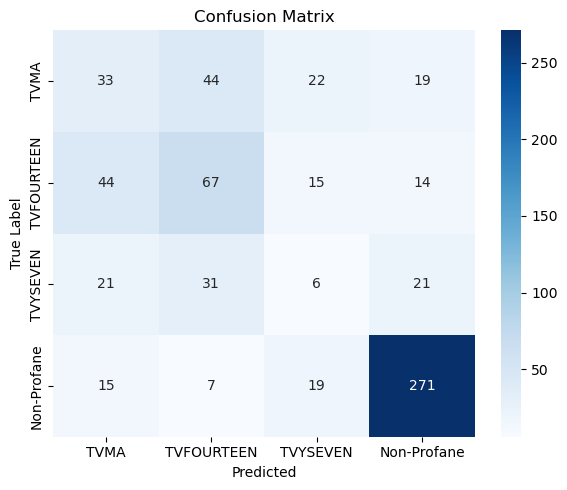

In [ ]:
# 6. Confusion Matrix
import seaborn as sns
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[id_to_label[i] for i in range(4)], yticklabels=[id_to_label[i] for i in range(4)])
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
import torchaudio
import torch
import matplotlib.pyplot as plt
from IPython.display import Audio

# Load trained model
model.load_state_dict(torch.load("best_astv7v2.pth", map_location=device))
model.eval().to(device)

# Parameters
sample_rate = 16000

# Prediction function
def predict_on_audio(file_path, model, mel_transform, db_transform, device,
                     window_sec=1.0, stride_sec=1.0, threshold=0.5):
    import torchaudio
    import torch

    waveform, sr = torchaudio.load(file_path)
    waveform = torchaudio.functional.resample(waveform, sr, 16000)
    waveform = waveform.mean(dim=0, keepdim=True)  # mono
    sr = 16000

    window_samples = int(window_sec * sr)
    stride_samples = int(stride_sec * sr)
    total_samples = waveform.shape[1]

    predictions = []
    segments = []
    confidences = []

    model.eval()

    for start in range(0, total_samples - window_samples + 1, stride_samples):
        end = start + window_samples
        segment = waveform[:, start:end]

        if segment.shape[1] < window_samples:
            segment = torch.nn.functional.pad(segment, (0, window_samples - segment.shape[1]))

        with torch.no_grad():
            mel = mel_transform(segment)
            mel_db = db_transform(mel)

            # Fix: ensure shape is [1, 1, H, W] for interpolate
            mel_db = mel_db.unsqueeze(0)  # [1, 1, Freq, Time]

            if mel_db.shape[-1] < 10 or mel_db.shape[-2] < 10:
                continue

            mel_resized = torch.nn.functional.interpolate(
                mel_db, size=(224, 224), mode='bilinear', align_corners=False
            ).to(device)

            out = torch.softmax(model(mel_resized), dim=1)
            pred_label = torch.argmax(out, dim=1).item()
            confidence = out[0, pred_label].item()

            if confidence >= threshold:
                predictions.append(pred_label)
                confidences.append(confidence)
            else:
                predictions.append(None)
                confidences.append(None)

            segments.append((start, end))

    return waveform.squeeze().numpy(), segments, predictions, confidences





/var/folders/c0/fzgnj9q11_78qpvqll__gxvw0000gn/T/ipykernel_76099/11796936.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_astv7v2.

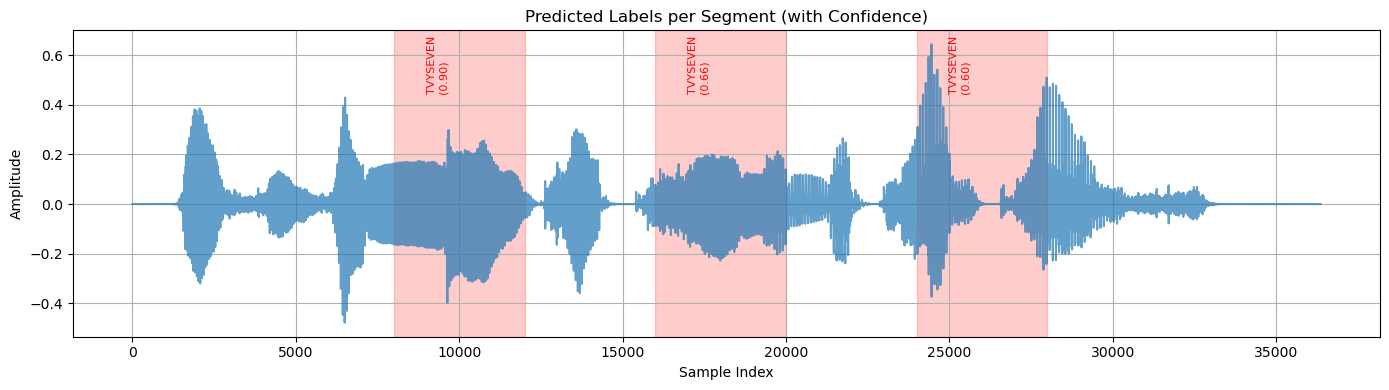

In [ ]:
audio_path = "/Users/raj/University/AVS 8/AVS8_AAU_Audio_Main/Synthetic Audio/Syn_Aud_categorized/profane/Taman/3932_profane.mp3"



waveform_np, segments, predictions, confidences = predict_on_audio(
    file_path=audio_path,
    model=model,
    mel_transform=mel_transform,
    db_transform=db_transform,
    device=device,
    window_sec=0.25,    
    stride_sec=0.5,
    threshold=0.4
)

plt.figure(figsize=(14, 4))
plt.plot(waveform_np, alpha=0.7)

for (start, end), label_id, conf in zip(segments, predictions, confidences):
    if label_id is not None:
        label = id_to_label[label_id]
        if label != "Non-Profane":
            plt.axvspan(start, end, color='red', alpha=0.2)
            label_text = f"{label}\n({conf:.2f})"
            plt.text(start + 1000, 0.45, label_text, color='red', fontsize=8, rotation=90)

plt.title("Predicted Labels per Segment (with Confidence)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()


Audio(audio_path)


/var/folders/c0/fzgnj9q11_78qpvqll__gxvw0000gn/T/ipykernel_76099/764543124.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_astv7v

🔍 Waveform mean amplitude: 0.028773
Confidence Summary — Max: 0.89, Min: 0.36, Mean: 0.59
🔍 Raw Confidences: [0.612332820892334, 0.6799923777580261, 0.35828787088394165, 0.8922438621520996, 0.48873430490493774, 0.43505531549453735, 0.8854992389678955, 0.4650617837905884, 0.49479493498802185]
🔍 Raw Predictions: ['TVFOURTEEN', 'TVFOURTEEN', 'None', 'Non-Profane', 'TVFOURTEEN', 'TVFOURTEEN', 'TVYSEVEN', 'TVFOURTEEN', 'TVYSEVEN']


/var/folders/c0/fzgnj9q11_78qpvqll__gxvw0000gn/T/ipykernel_76099/764543124.py:149: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


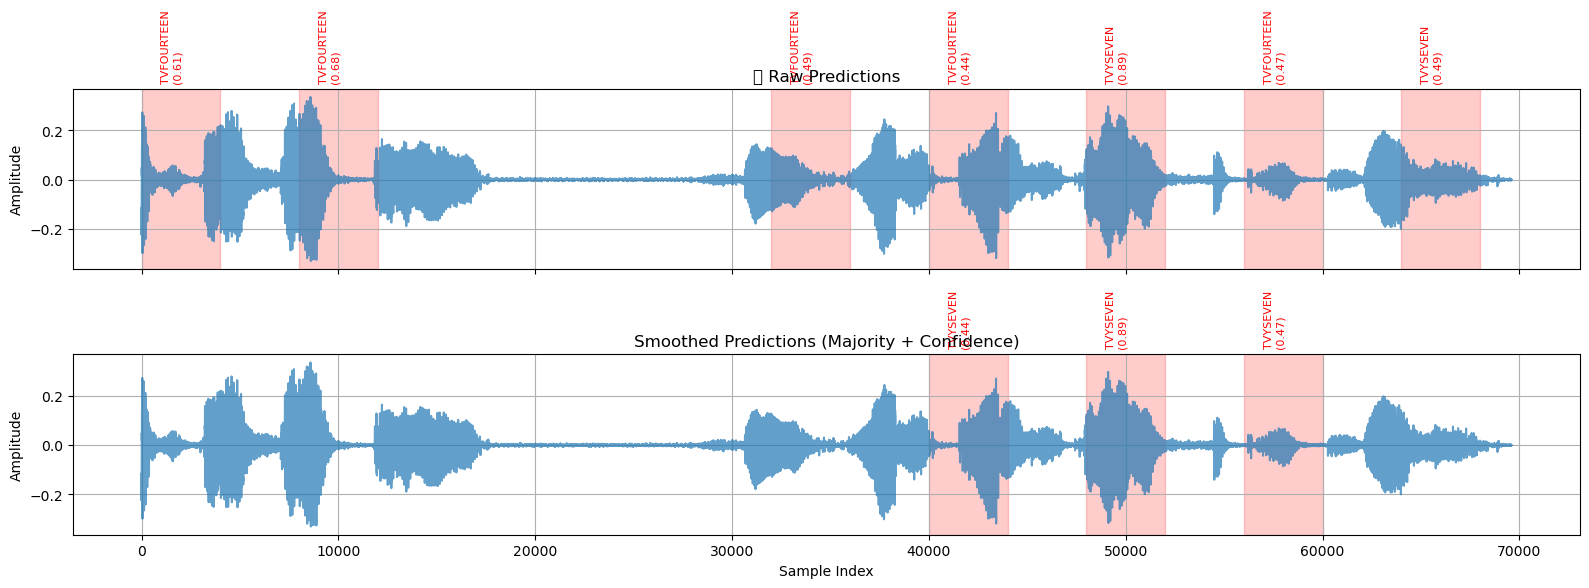

In [ ]:
# 1. Imports & Setup
import torch
import torchaudio
import matplotlib.pyplot as plt
from IPython.display import Audio
from timm.models import create_model
import numpy as np

#  2. Load Model & Weights
#  Use in_chans=1 to match trained checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model("vit_base_patch16_224", pretrained=False, num_classes=4, in_chans=1)
model.load_state_dict(torch.load("best_astv7v2.pth", map_location=device))
model = model.to(device)
model.eval()

#  3. Transforms
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=16000, n_fft=1024, hop_length=320, n_mels=128
)
db_transform = torchaudio.transforms.AmplitudeToDB(top_db=80)

label_to_id = {"TVMA": 0, "TVFOURTEEN": 1, "TVYSEVEN": 2, "Non-Profane": 3}
id_to_label = {v: k for k, v in label_to_id.items()}

#  4. Prediction Function (Safe)
def predict_on_audio(file_path, model, mel_transform, db_transform, device,
                     window_sec=2.0, stride_sec=1.0, threshold=0.7):
    waveform, sr = torchaudio.load(file_path)
    waveform = torchaudio.functional.resample(waveform, sr, 16000)
    waveform = waveform.mean(dim=0, keepdim=True)

    print(f" Waveform mean amplitude: {waveform.abs().mean().item():.6f}")

    sr = 16000
    window_samples = int(window_sec * sr)
    stride_samples = int(stride_sec * sr)
    total_samples = waveform.shape[1]

    predictions, confidences, segments = [], [], []

    for start in range(0, total_samples - window_samples + 1, stride_samples):
        end = start + window_samples
        segment = waveform[:, start:end]

        if segment.shape[1] < window_samples:
            segment = torch.nn.functional.pad(segment, (0, window_samples - segment.shape[1]))

        with torch.no_grad():
            mel = mel_transform(segment)
            mel_db = db_transform(mel)  # [1, H, T]
            mel_db = mel_db.unsqueeze(0)  # [1, 1, H, T]

            if mel_db.ndim != 4:
                continue

            mel_resized = torch.nn.functional.interpolate(
                mel_db, size=(224, 224), mode='bilinear', align_corners=False
            ).to(device)

            out = torch.softmax(model(mel_resized), dim=1)
            pred_label = torch.argmax(out, dim=1).item()
            confidence = out[0, pred_label].item()

            predictions.append(pred_label if confidence >= threshold else None)
            confidences.append(confidence)
            segments.append((start, end))

    return waveform.squeeze().cpu().numpy(), segments, predictions, confidences

#  5. Smoothing

def smooth_predictions_with_confidence(predictions, confidences, kernel_size=3, conf_threshold=0.3):
    smoothed_preds = []
    pad = kernel_size // 2
    padded_preds = [None] * pad + predictions + [None] * pad
    padded_confs = [0.0] * pad + confidences + [0.0] * pad

    for i in range(len(predictions)):
        window_preds = padded_preds[i:i + kernel_size]
        window_confs = padded_confs[i:i + kernel_size]

        filtered = [(p, c) for p, c in zip(window_preds, window_confs) if p is not None and c >= conf_threshold]
        if filtered:
            labels, confs = zip(*filtered)
            label_counts = {}
            for l, c in filtered:
                if l not in label_counts or c > label_counts[l]:
                    label_counts[l] = c
            top_label = max(label_counts, key=label_counts.get)
            smoothed_preds.append(top_label)
        else:
            smoothed_preds.append(None)

    return smoothed_preds

# 6. Predict + Plot both Raw and Smoothed

audio_path = "/Users/raj/University/AVS 8/AVS8_AAU_Audio_Main/Synthetic Audio/Syn_Aud_categorized/profane/real1.mp3"

# audio_path = "/Users/raj/University/AVS 8/AVS8_AAU_Audio_Main/Synthetic Audio/Syn_Aud_categorized/non_profane/3177_non_profane.mp3"


waveform_np, segments, predictions, confidences = predict_on_audio(
    file_path=audio_path,
    model=model,
    mel_transform=mel_transform,
    db_transform=db_transform,
    device=device,
    window_sec=.25,
    stride_sec=.5,
    threshold=0.4
)

if len(confidences) == 0:
    print(" No confident predictions found. Try reducing threshold or checking audio.")
else:
    print(f"Confidence Summary — Max: {max(confidences):.2f}, Min: {min(confidences):.2f}, Mean: {np.mean(confidences):.2f}")
    print(f" Raw Confidences: {confidences}")
    print(f" Raw Predictions: {[id_to_label.get(p) if p is not None else 'None' for p in predictions]}")


    # smothed prediction parameters 

    smoothed_preds = smooth_predictions_with_confidence(predictions, confidences, kernel_size=3, conf_threshold=0.7)

    fig, axs = plt.subplots(2, 1, figsize=(16, 6), sharex=True)

    axs[0].plot(waveform_np, alpha=0.7)
    axs[0].set_title(" Raw Predictions")
    for (start, end), label_id, conf in zip(segments, predictions, confidences):
        if label_id is not None and id_to_label[label_id] != "Non-Profane":
            label_text = f"{id_to_label[label_id]}\n({conf:.2f})"
            axs[0].axvspan(start, end, color='red', alpha=0.2)
            axs[0].text(start + 1000, 0.4, label_text, color='red', fontsize=8, rotation=90)

    axs[1].plot(waveform_np, alpha=0.7)
    axs[1].set_title("Smoothed Predictions (Majority + Confidence)")
    for (start, end), label_id, conf in zip(segments, smoothed_preds, confidences):
        if label_id is not None and id_to_label[label_id] != "Non-Profane":
            label_text = f"{id_to_label[label_id]}\n({conf:.2f})"
            axs[1].axvspan(start, end, color='red', alpha=0.2)
            axs[1].text(start + 1000, 0.4, label_text, color='red', fontsize=8, rotation=90)

    for ax in axs:
        ax.set_ylabel("Amplitude")
        ax.grid(True)
    axs[1].set_xlabel("Sample Index")
    plt.tight_layout()
    plt.show()

    display(Audio(audio_path))
